## Exploring the data
Before training a model, we need to learn about the data we want to use. In the following, we will:

1. Conduct an explorative analysis of the data,
2. Preprocess the data,
4. Prepare the data to be used to train a model.

#### What is the goal?
First, we need to define what we actually want to do and what data we will need for that. In this case, we want to train an AI model to automatically route customer support tickets to the correct department.

## Explorative Analysis
We first take a look a the data, to determine what is of use for our goal.

In [1]:
import pandas as pd
filepath = "../data/dataset_en.csv"
df = pd.read_csv(filepath)
df

,subject,body,answer,type,queue,priority,language,version,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8
0,Account Disruption,"Dear Customer Support Team,\n\nI am writing to...","Thank you for reaching out, <name>. We are awa...",Incident,Technical Support,high,en,51,Account,Disruption,Outage,IT,Tech Support,NaN,NaN,NaN
1,Query About Smart Home System Integration Feat...,"Dear Customer Support Team,\n\nI hope this mes...",Thank you for your inquiry. Our products suppo...,Request,Returns and Exchanges,medium,en,51,Product,Feature,Tech Support,NaN,NaN,NaN,NaN,NaN
2,Inquiry Regarding Invoice Details,"Dear Customer Support Team,\n\nI hope this mes...",We appreciate you reaching out with your billi...,Request,Billing and Payments,low,en,51,Billing,Payment,Account,Documentation,Feedback,NaN,NaN,NaN
3,Question About Marketing Agency Software Compa...,"Dear Support Team,\n\nI hope this message reac...",Thank you for your inquiry. Our product suppor...,Problem,Sales and Pre-Sales,medium,en,51,Product,Feature,Feedback,Tech Support,NaN,NaN,NaN,NaN
4,Feature Query,"Dear Customer Support,\n\nI hope this message ...",Thank you for your inquiry. Please specify whi...,Request,Technical Support,high,en,51,Feature,Product,Documentation,Feedback,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16333,Problem with Billing Adjustment,An unexpected billing discrepancy has been not...,We apologize for the billing discrepancy in th...,Incident,Billing and Payments,high,en,400,Billing,Payment,Performance,Bug,NaN,NaN,NaN,NaN
16334,Urgent: Incident Involving Data Breach in Medi...,"A data breach has occurred, which might be rel...","Dear [Name], we acknowledge the urgency of the...",Problem,Product Support,medium,en,400,Security,Incident,Bug,Performance,NaN,NaN,NaN,NaN
16335,Performance Problem with Data Analytics Tool,The data analytics tool experiences sluggish p...,We are addressing the performance issue with t...,Incident,Technical Support,high,en,400,Performance,IT,Tech Support,NaN,NaN,NaN,NaN,NaN
16336,Update Request for SaaS Platform Integration F...,Requesting an update on the integration featur...,Received your request for updates on the integ...,Change,IT Support,high,en,400,Feature,IT,Tech Support,NaN,NaN,NaN,NaN,NaN


### What data to keep?
Looking at the data, a few things look helpful. The 'subject' of a ticket, the 'body' that contain the contents of a customer support ticket and the 'queue' that specifies the department to which the ticket is categorized are perfect for the intended use case. To keep features low, 'subject' and body' are combined into one. Furthermore we will include 'priority', since this is an important information in real world scenarios.

The rest of the data is either 'metadata' or not relevant for our system and can be savely excluded. As such, we will only keep 'body', 'queue' and 'priority'.

In [2]:
# We fill empty values with empty strings to avoid errors
df["body"] = df["subject"].fillna("") + ". " + df["body"].fillna("")
df = df[["body","queue","priority"]]
df

,body,queue,priority
0,Account Disruption. Dear Customer Support Team...,Technical Support,high
1,Query About Smart Home System Integration Feat...,Returns and Exchanges,medium
2,Inquiry Regarding Invoice Details. Dear Custom...,Billing and Payments,low
3,Question About Marketing Agency Software Compa...,Sales and Pre-Sales,medium
4,"Feature Query. Dear Customer Support,\n\nI hop...",Technical Support,high
...,...,...,...
16333,Problem with Billing Adjustment. An unexpected...,Billing and Payments,high
16334,Urgent: Incident Involving Data Breach in Medi...,Product Support,medium
16335,Performance Problem with Data Analytics Tool. ...,Technical Support,high
16336,Update Request for SaaS Platform Integration F...,IT Support,high


### Clean some data
Some of the 'body' contents have "\n\n" in the text, indicating a paragraph. We will remove these, since they are clutter and may negativly impact further processing.

In [3]:
df.loc[:, "body"] = df["body"].str.replace("\\n\\n", " ", regex=False)
df["body"]

0        Account Disruption. Dear Customer Support Team...
1        Query About Smart Home System Integration Feat...
2        Inquiry Regarding Invoice Details. Dear Custom...
3        Question About Marketing Agency Software Compa...
4        Feature Query. Dear Customer Support, I hope t...
                               ...                        
16333    Problem with Billing Adjustment. An unexpected...
16334    Urgent: Incident Involving Data Breach in Medi...
16335    Performance Problem with Data Analytics Tool. ...
16336    Update Request for SaaS Platform Integration F...
16337    Inquiry About Project Management Features. Loo...
Name: body, Length: 16338, dtype: object

### Taking a look at the data distribution
Next, we take a look on some stats, including the distribution of different ticket 'body' lenghts, tickets per 'queue' item and distribution of 'priority'.
First, some genral statistics for the ticket 'body':
- Median Wordcount: 58.89
- Median Wordcount: 60
- Shortest Message(s): 4 words
- Longest Message(s): 175 words
- There was a single "one word" ticket, which read 'Thecompanyisincapableofaccessinginvestmentanalyticsduetosystemunavailability.'. Obviously this is a mistake and since its only one, this was fixed manually.

#### Distribution of ticket lenghts
The histogram below shows, that overall most of the messages contain between ~25 and ~100 words, meaning there are not many outliers.

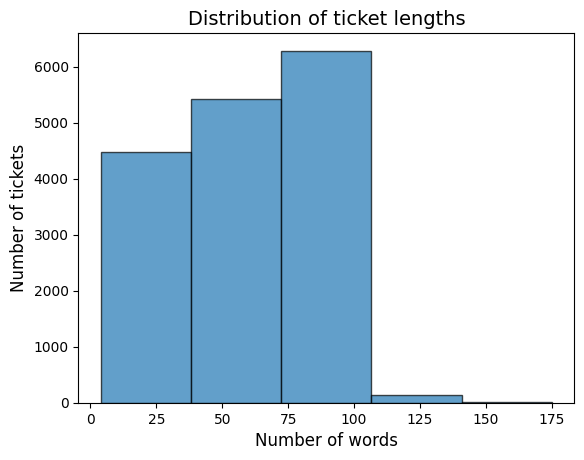

In [4]:
import matplotlib.pyplot as plt

# Calculates the lenght of each entry in the 'body' column
ticket_lengths = [len(x.split()) for x in df["body"]] 

plt.hist(ticket_lengths, bins=5, edgecolor='black', alpha=0.7)
plt.xlabel('Number of words', fontsize=12)  
plt.ylabel('Number of tickets', fontsize=12)  
plt.title('Distribution of ticket lengths', fontsize=14)
plt.show() 

#### Distribution of tickets per department
Next we take a look at how many tickets are present per department. This will later be relevant, to avoid bias. The graphic below shows that the distribution of tickets to department is rather uneven. This means, we will need to even this out later to avoid bias in the model  train.

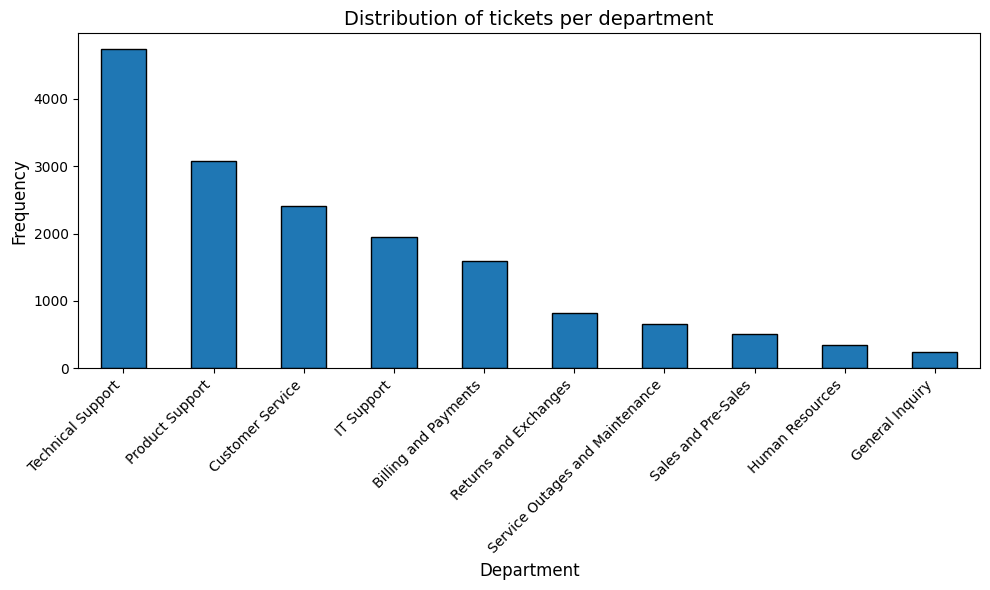

In [5]:
department_tickets = df["queue"].value_counts()

plt.figure(figsize=(10, 6))
department_tickets.plot(kind='bar', edgecolor='black')
plt.xlabel('Department', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of tickets per department', fontsize=14)
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.show()

#### Mean word count by department
To further explore the distribution of tickets by department, we calculate the median number of words for all messages ('body' contents) by department ('queue' contents). We use the median, since we have seen earlier that there are some strong outliers when it come to message lenght (overall the medians and the means are rather close anyways). 

First, we need to define some functions that help us the extract an dprocess the relvant data:

In [6]:
import statistics as st

'''
Calculates the median length of a list of strings.

Args:
    - tickets: Input list. Should be a list of strings, representing the ticket bodies.
Return:
    - float that represents the median length of the texts in the input list
'''
def calculate_median(tickets: list[str]) -> float:
    ticket_lengths = [len(x.split()) for x in tickets]  
    median = st.median(ticket_lengths)
    return median

'''
Calculates the median word count for all messages related to the different departments. 
Returns a list of tuples containing a department and the median word count of the all tickets associated with the department

Args:
    - departments: Input list. Should be a list of strings, representing the departments found in 'queue'.
Return:
    - list of tuples, containing a department and the median wordcount of the 'body' contents associated with it
'''
def median_per_department(departments :list[str]) -> list[tuple]:
    medians = []
    for d in departments:
        # Get each entry in the 'body' column where in the same row the content of the 'queue' column is the department d
        department_bodies = df.loc[df['queue'] == d, 'body']
        # Calculate the median number of words across all messages
        median = calculate_median(department_bodies)  
        medians.append((d,median))
    return medians


When looking at the resulting graphics, we can see that the median amount of words of the messages for each department is rather balanced. As such, we will not need to take the message length as much into account when training the model later on.

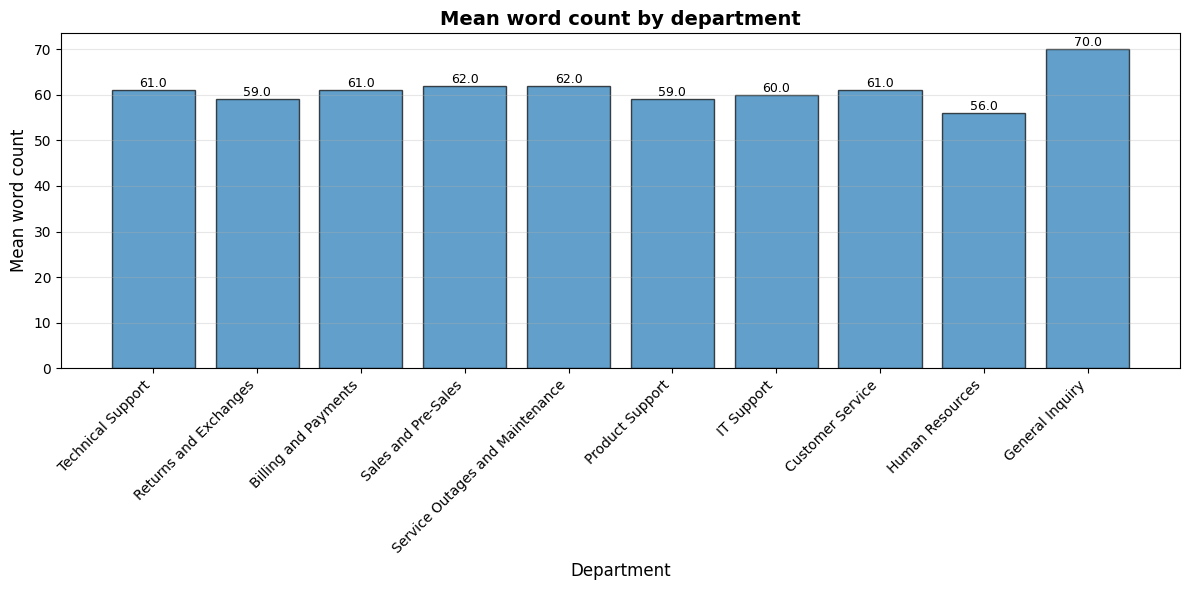

In [7]:
departments = df["queue"].unique()
data = median_per_department(departments)

queues = [item[0] for item in data]
medians = [item[1] for item in data]

plt.figure(figsize=(12, 6))
bars = plt.bar(queues, medians, edgecolor='black', alpha=0.7)

plt.xlabel('Department', fontsize=12)
plt.ylabel('Mean word count', fontsize=12)
plt.title('Mean word count by department', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

#### Distribution of tickets per priority

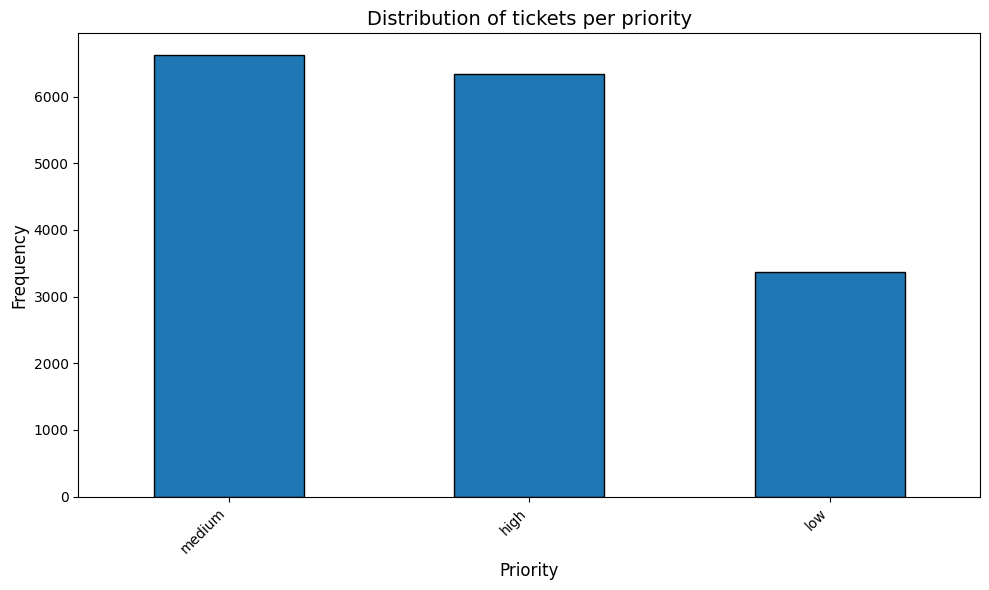

In [8]:
department_tickets = df["priority"].value_counts()

plt.figure(figsize=(10, 6))
department_tickets.plot(kind='bar', edgecolor='black')
plt.xlabel('Priority', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of tickets per priority', fontsize=14)
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.show()